# Homework 3 - Adversarial Attacks and Contrastive Learning

### Submission in pairs unless otherwise authorized
<ul>
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for the practical parts should be written in this notebook/py (see submission files) and for the theoretical parts in a pdf report. </li>
</ul>

<h3> Moodle submission</h3>


<p>
You should submit the following files:
</p>
<ul">
<li> Code files:
<ul>
  You can choose 1 of the following options:
  <li>IPYNB notebook:
    <ul>
    <li>All the wet, including the code</li>
    </ul>
  </li>
  <li>PY files:
    <ul>
    <li>4 <code>.py</code> files, one for each question. Submission format for <code>.py</code> files -  HW3_Qn_ID1_ID2.py where n is the question number.</li>
    </ul>
  </li>
</ul>
<li>PDF file - report:
  <ul>
  <li>Answers for all the dry parts - analysis, visualization, dry questions, embeddings.</li>
  </ul>
</li>
</ul>
<p>
All files should be in the following format: "HW3_ID1_ID2.file"
<br>
Good Luck!
</p>

Libraries that can be used in this assignment:

- PyTorch (torch, torchvision, torch.optim, torch.nn, ...) -- Any other deep learning libraries such as keras are prohibited
- NumPy
- Any libraries used for visualization
- PIL (for image processing)

For any libraries other than those listed above, you may ask in the forum.

## Part 1 - Training a CNN on SVHN

Train a classifier on the dataset SVHN (Street View House Numbers), available through ```torchvision.datasets```. The model accuracy should reach at least 90% on the test set. You're free to add as many data augmentations as necessary. Take into consideration that any serious augmentations (like normalization) should be reversed when displaying images in future sections.

In [1]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms, datasets

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load SVHN dataset
train_dataset = datasets.SVHN(root='./data', split='train', transform=transform_train, download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Training loop with train and test accuracy
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total

        # Testing phase
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_accuracy = 100 * test_correct / test_total

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, 5)


# Evaluate the model
accuracy = evaluate_model(model, test_loader)

# Define function to inverse normalize and display images
def show_images(images, labels, class_names):
    images = images / 2 + 0.5  # Inverse normalization
    np_images = images.numpy()
    plt.figure(figsize=(10, 10))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(np.transpose(np_images[i], (1, 2, 0)))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()



100%|██████████| 182M/182M [00:21<00:00, 8.55MB/s]


100%|██████████| 64.3M/64.3M [00:05<00:00, 12.1MB/s]


Epoch [1/5], Loss: 0.8279, Train Accuracy: 73.21%, Test Accuracy: 86.12%
Epoch [2/5], Loss: 0.4905, Train Accuracy: 84.64%, Test Accuracy: 89.52%
Epoch [3/5], Loss: 0.4202, Train Accuracy: 87.03%, Test Accuracy: 90.69%
Epoch [4/5], Loss: 0.3828, Train Accuracy: 88.22%, Test Accuracy: 91.15%
Epoch [5/5], Loss: 0.3519, Train Accuracy: 89.30%, Test Accuracy: 92.19%
Test Accuracy: 92.19%


### Analysis

Analyze the performance of the model on the test set (e.g. through a confusion matrix). Display images that the model predicts incorrectly and their predicted classes. Discuss possible weaknesses of the model and their causes.

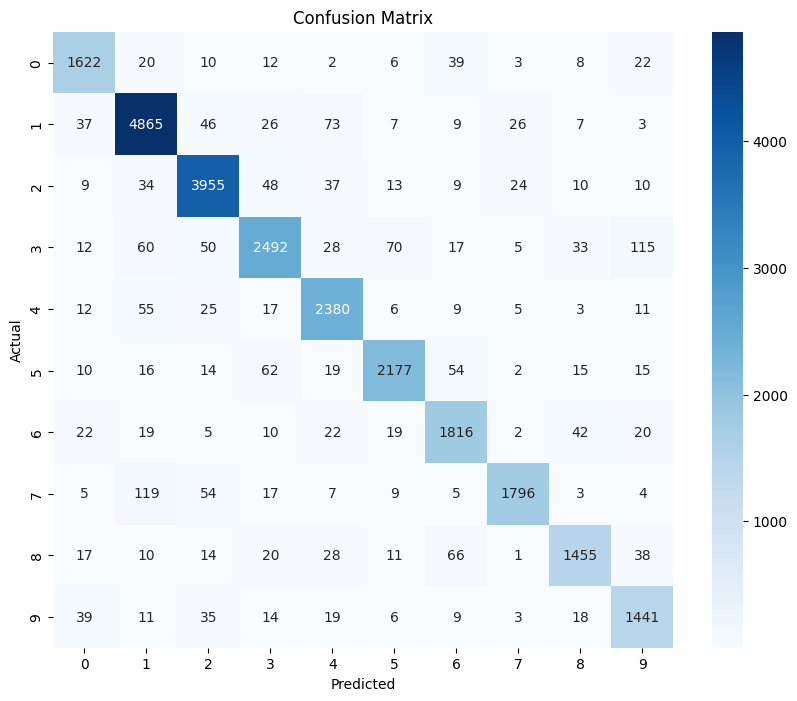

              precision    recall  f1-score   support

           0     0.9087    0.9300    0.9192      1744
           1     0.9340    0.9541    0.9439      5099
           2     0.9399    0.9532    0.9465      4149
           3     0.9169    0.8647    0.8900      2882
           4     0.9101    0.9433    0.9264      2523
           5     0.9367    0.9132    0.9248      2384
           6     0.8933    0.9186    0.9057      1977
           7     0.9620    0.8895    0.9243      2019
           8     0.9128    0.8765    0.8943      1660
           9     0.8582    0.9034    0.8803      1595

    accuracy                         0.9219     26032
   macro avg     0.9173    0.9147    0.9156     26032
weighted avg     0.9224    0.9219    0.9218     26032



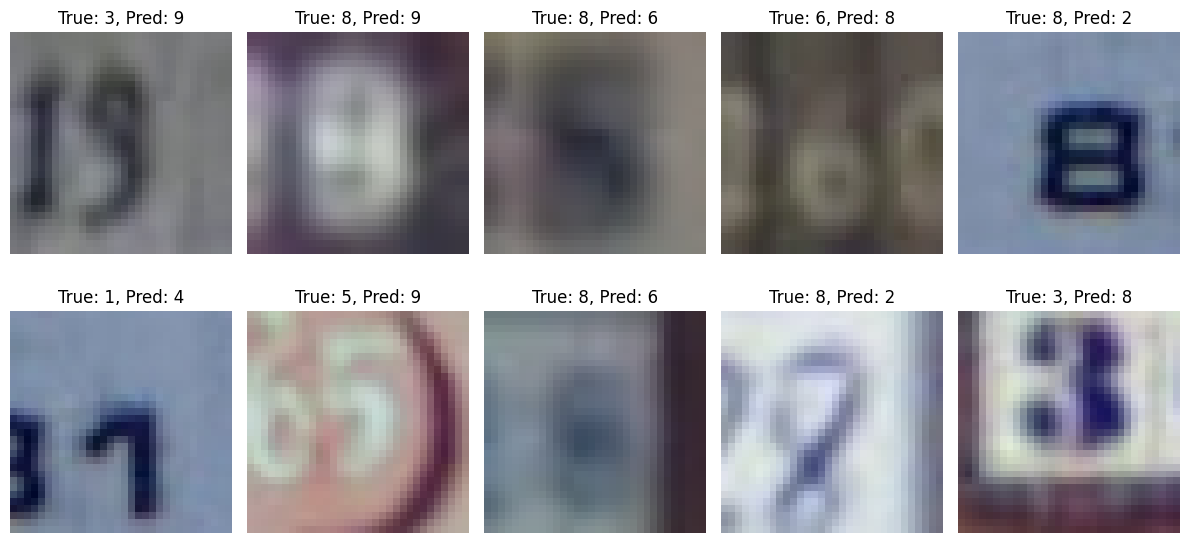

In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Generate predictions and calculate confusion matrix
def analyze_performance(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(all_labels, all_preds, digits=4))

    return np.array(all_preds), np.array(all_labels)

# Visualize misclassified images
def visualize_misclassifications(model, loader, device):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            for img, label, pred in zip(inputs, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))
                if len(misclassified) >= 10:  # Display up to 10 misclassified images
                    break
            if len(misclassified) >= 10:
                break

    # Plot misclassified images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(10):
        img, true_label, pred_label = misclassified[i]
        img = img.permute(1, 2, 0)* 0.5 + 0.5
        img = img.numpy()
        img = np.clip(img, 0, 1)  # Clip values for display
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}, Pred: {pred_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Analyze and visualize performance
all_preds, all_labels = analyze_performance(model, test_loader, device)
visualize_misclassifications(model, test_loader, device)


The model demonstrates a reasonable overall accuracy of 92.19%, but several weaknesses are evident. Misclassifications often occur between visually similar digits, such as 9 and 3 or 8 and 6, which is probably due to the similarity of the digit's structure.

## Part 2: Adversarial Attacks on our Model

Implement the FGSM algorithm as shown in the tutorial (it may be necessary to make require_grad be True for our input data in order to calculate its gradient). Define a function ```eval_adversarial(model, test_loader, epsilon)``` that applies FGSM on the test data by creating new images which are perturbed versions of the originals, and calculates the model's accuracy only on the perturbed images. Test accuracy after the attack should be less than 25% for $\varepsilon=0.1$.

In [3]:
#new
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# FGSM attack function (same as before)
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Evaluate adversarial accuracy and collect misclassified examples
def eval_adversarial(model, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    misclassified_images = []
    perturbed_batches = []

    # Loop over the test dataset
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True  # Enable gradients for inputs

        # Forward pass
        outputs = model(inputs)
        _, preds = outputs.max(1)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Zero existing gradients
        model.zero_grad()

        # Backpropagate to get gradients of the inputs
        loss.backward()

        # Get the gradients
        data_grad = inputs.grad

        # Generate adversarial examples
        perturbed_inputs = fgsm_attack(inputs, epsilon, data_grad)
        perturbed_batches.append(perturbed_inputs.cpu())  # Store entire batch

        # Re-evaluate the model on the perturbed inputs
        outputs = model(perturbed_inputs)
        _, perturbed_preds = outputs.max(1)

        # Update accuracy and predictions
        correct += (perturbed_preds == labels).sum().item()
        total += labels.size(0)

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(perturbed_preds.cpu().numpy())

        # Track misclassified examples (correct before, wrong after)
        for img_idx, (img, true_label, pred, perturbed_pred) in enumerate(zip(inputs, labels, preds, perturbed_preds)):
            if true_label == pred and perturbed_pred != true_label:
                misclassified_images.append((img.cpu(), true_label.cpu(), perturbed_pred.cpu(), batch_idx, img_idx))

    # Calculate accuracy on adversarial examples
    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')

    return accuracy, all_labels, all_preds, misclassified_images, perturbed_batches


# Example usage:
# Assuming `model` is your trained model, `test_loader` is your test data loader
# and `device` is the device (CPU or GPU)
accuracy, all_labels, all_preds, misclassified_images, pertupeted = eval_adversarial(model, test_loader, epsilon=0.1)

print(accuracy)


Accuracy on adversarial examples: 16.23%
16.22618315918869


Visualize some images that the model got right before the perturbation and wrong after the attack. Create a confusion matrix of the output on the entire test set.

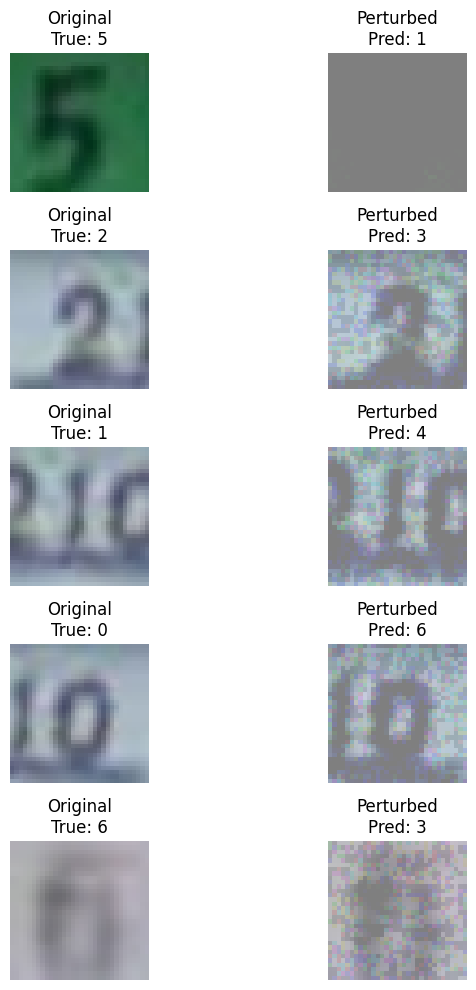

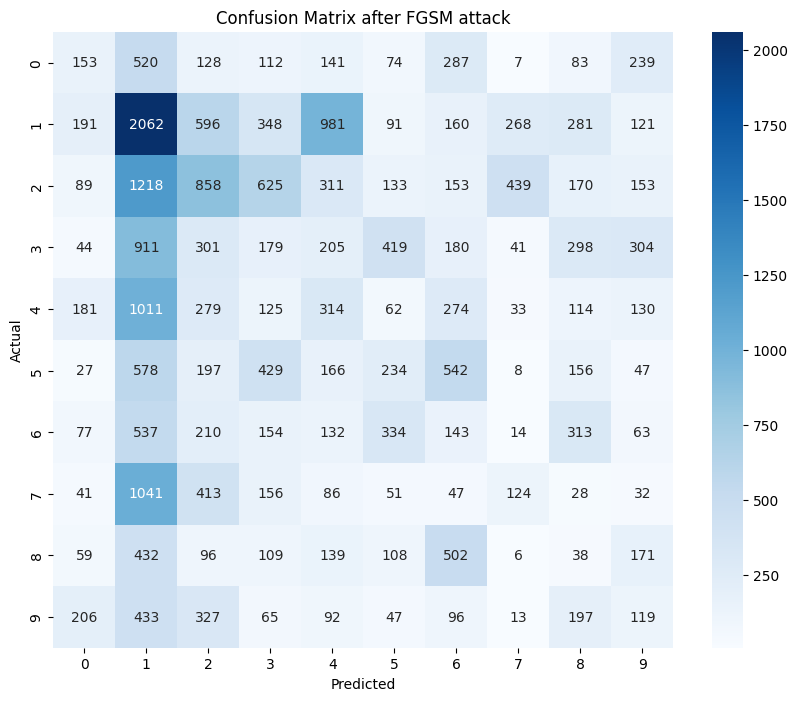

In [4]:
def visualize_perturbed_images(misclassified_images, perturbed_batches, epsilon):
    if misclassified_images:
        num_images = min(5, len(misclassified_images))  # Limit to 10 examples
        fig, axes = plt.subplots(num_images, 2, figsize=(8, 2 * num_images))

        for i in range(num_images):
            original_img, true_label, pred_label = misclassified_images[i]

            # Find corresponding perturbed image
            for batch in perturbed_batches:
                for perturbed_img in batch:
                    if torch.equal(original_img, perturbed_img):  # Compare tensors
                        continue
                    break  # Found the correct perturbed version

            # Convert images to numpy
            original_img = original_img.detach().cpu().permute(1, 2, 0).numpy()
            perturbed_img = perturbed_img.detach().cpu().permute(1, 2, 0).numpy()

            # Normalize images to [0,1] range
            original_img = np.clip(original_img * 0.5 + 0.5, 0, 1)
            perturbed_img = np.clip(perturbed_img * 0.5 + 0.5, 0, 1)

            # Plot original image
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title(f"Original\nTrue: {true_label}")
            axes[i, 0].axis('off')

            # Plot perturbed image
            axes[i, 1].imshow(perturbed_img)
            axes[i, 1].set_title(f"Perturbed (ε={epsilon})\nPred: {pred_label}")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()


def visualize_misclassifications(misclassified_images, perturbed_batches):
    if misclassified_images:
        num_images = min(5, len(misclassified_images))  # Limit to 5 examples
        fig, axes = plt.subplots(num_images, 2, figsize=(8, 2 * num_images))

        for i in range(num_images):
            original_img, true_label, pred_label, batch_idx, img_idx = misclassified_images[i]

            # Retrieve the corresponding perturbed image from the same batch
            perturbed_img = perturbed_batches[batch_idx][img_idx]

            # Convert images to numpy
            original_img = original_img.detach().cpu().permute(1, 2, 0).numpy()
            perturbed_img = perturbed_img.detach().cpu().permute(1, 2, 0).numpy()

            # Normalize images to [0,1] range
            original_img = np.clip(original_img * 0.5 + 0.5, 0, 1)
            perturbed_img = np.clip(perturbed_img * 0.5 + 0.5, 0, 1)

            # Plot original image
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title(f"Original\nTrue: {true_label}")
            axes[i, 0].axis('off')

            # Plot perturbed image
            axes[i, 1].imshow(perturbed_img)
            axes[i, 1].set_title(f"Perturbed\nPred: {pred_label}")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()



# Function to plot confusion matrix
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix after FGSM attack')
    plt.show()

# Visualize the misclassified images
visualize_misclassifications(misclassified_images, pertupeted)

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)

Test the function with different values of epsilon (at least 5) and plot the accuracy as a function of epsilon. For each epsilon, display the perturbed images with the model's classification. At what epsilon does it become harder for the human eye to correctly classify?

Accuracy on adversarial examples: 55.08%
Visualizing perturbed images for epsilon = 0.01


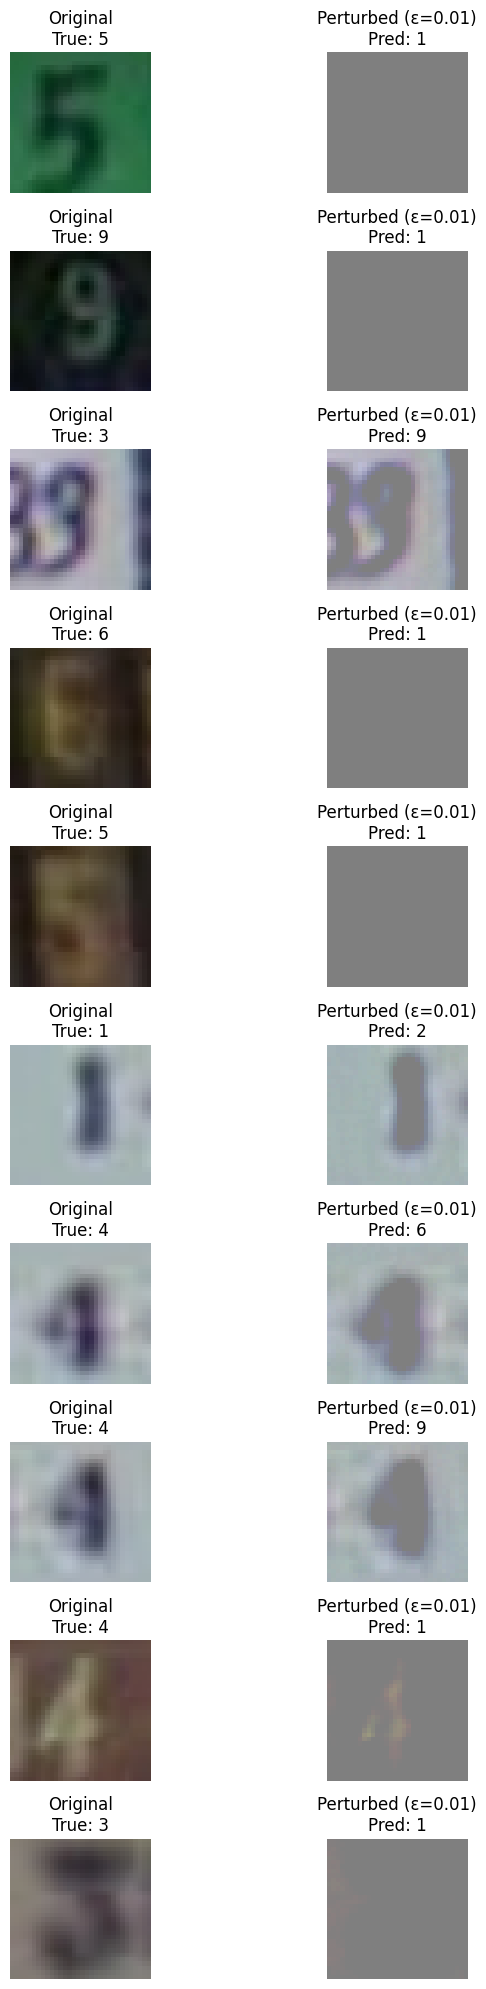

Accuracy on adversarial examples: 27.47%
Visualizing perturbed images for epsilon = 0.05


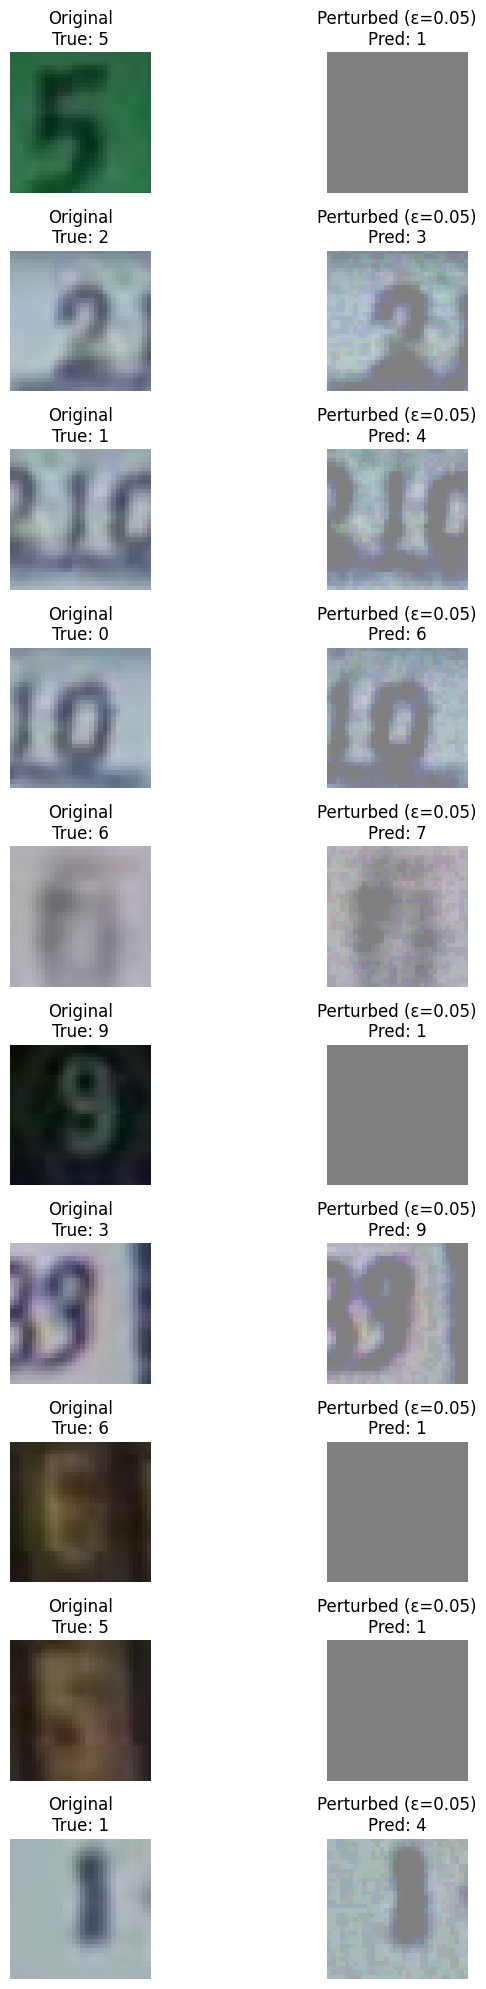

Accuracy on adversarial examples: 16.23%
Visualizing perturbed images for epsilon = 0.1


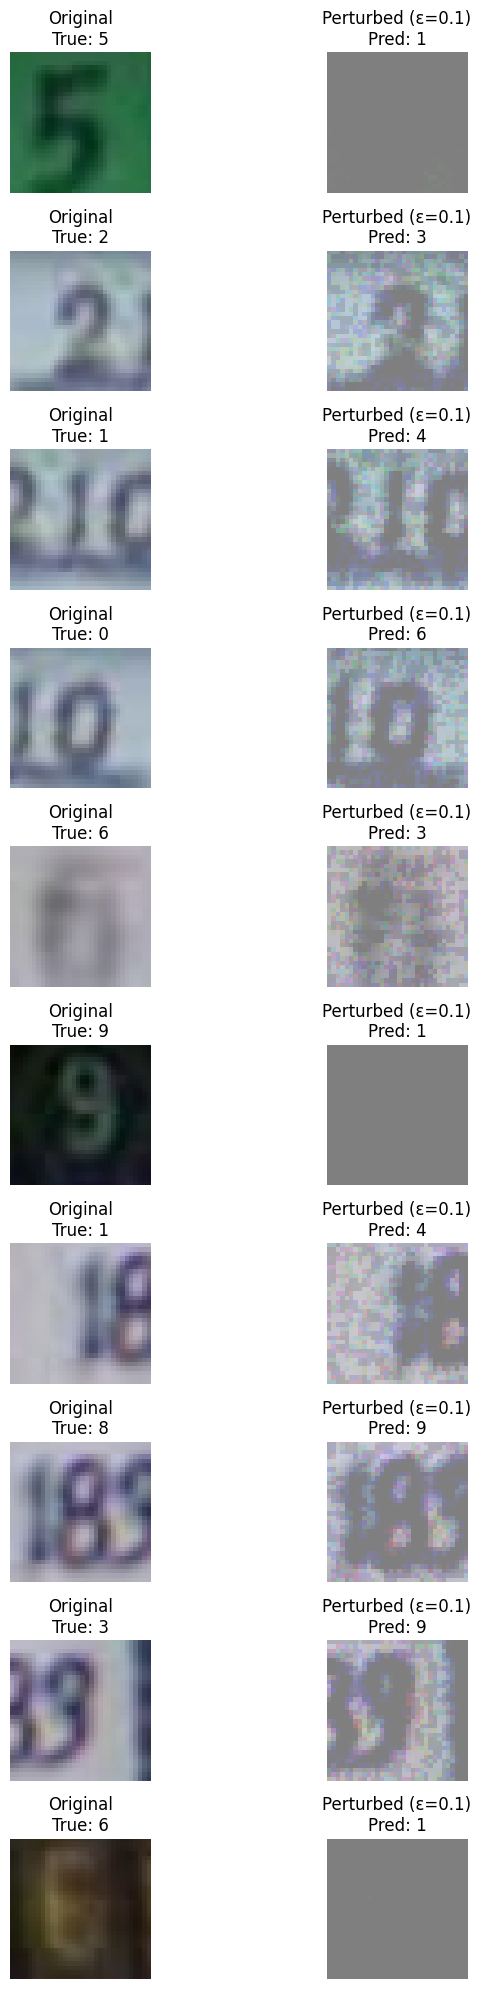

Accuracy on adversarial examples: 9.73%
Visualizing perturbed images for epsilon = 0.2


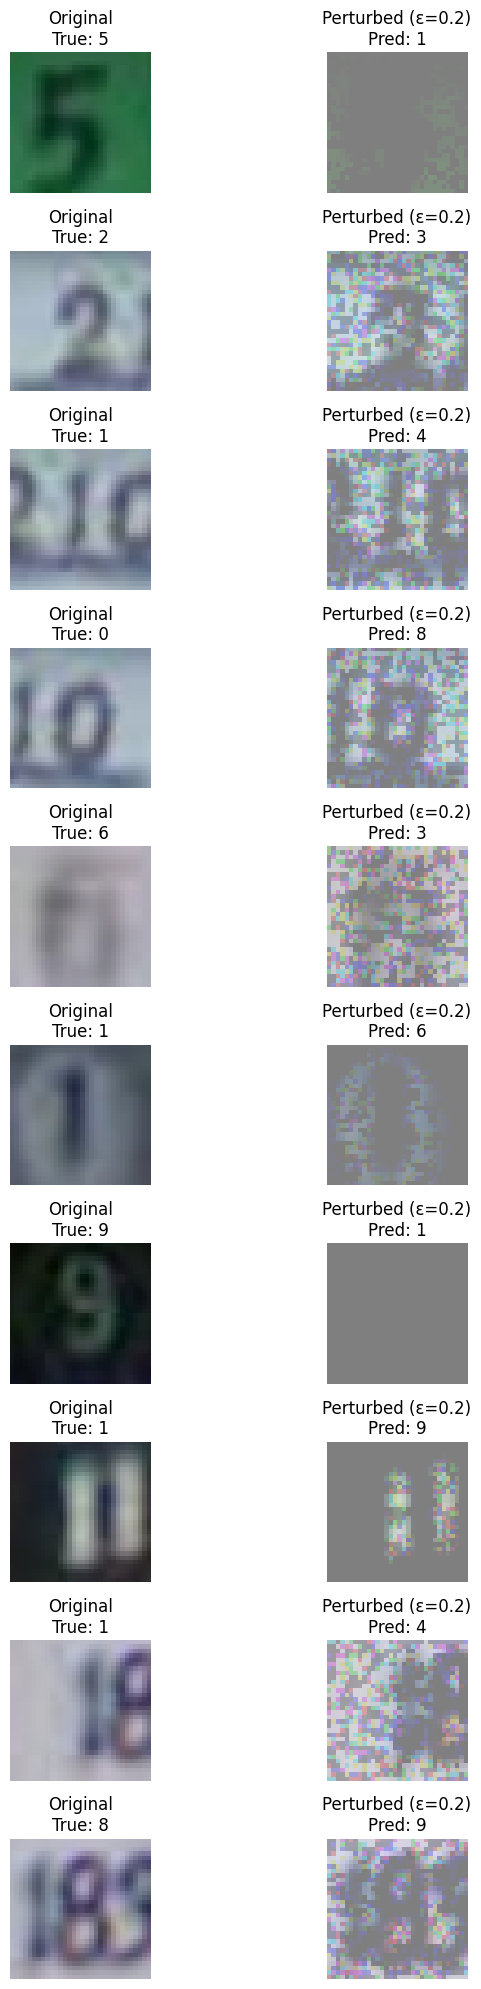

Accuracy on adversarial examples: 7.65%
Visualizing perturbed images for epsilon = 0.3


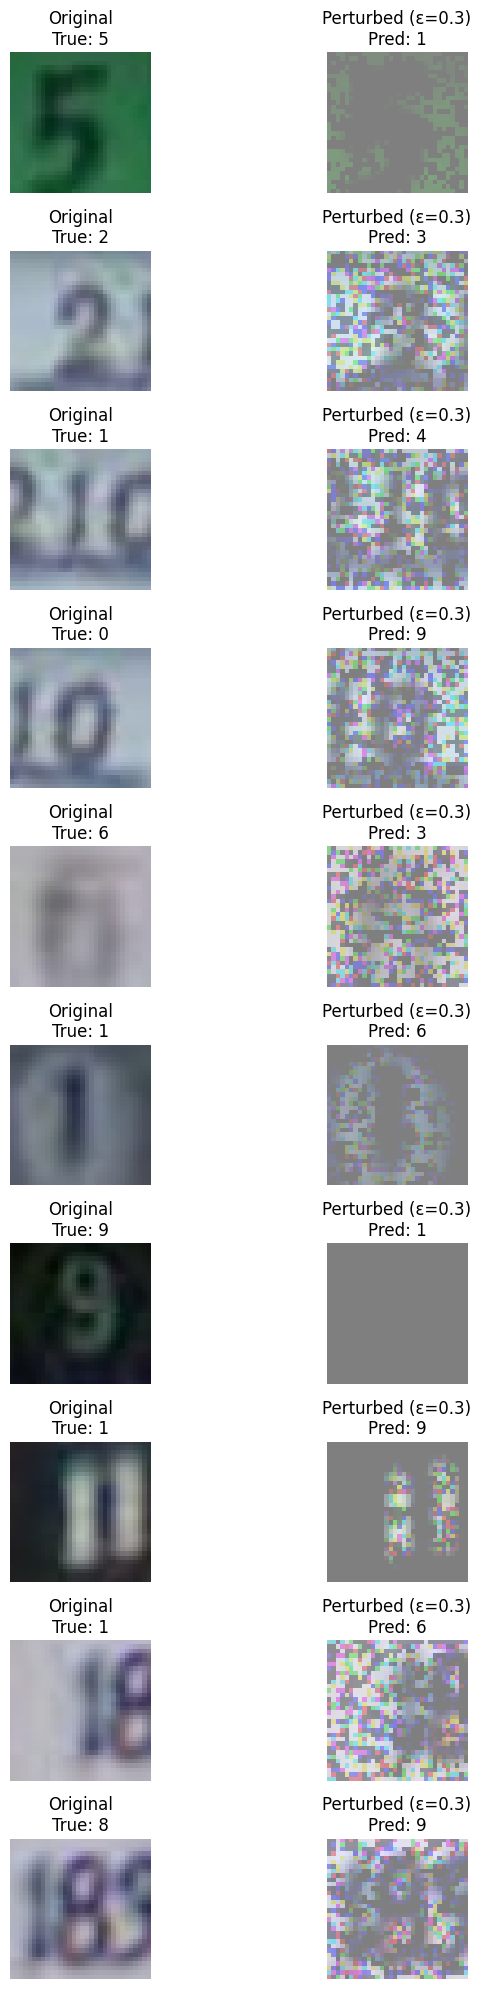

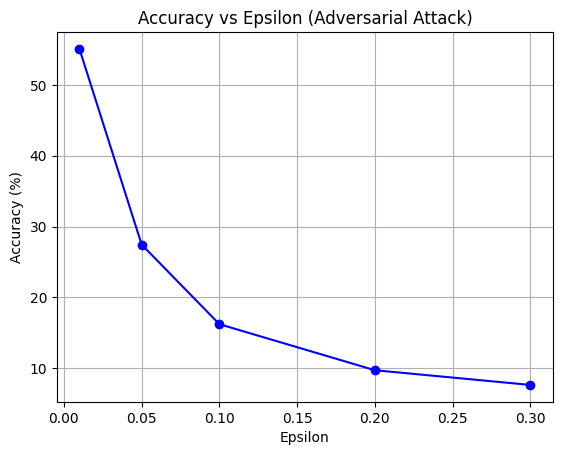

In [5]:
# new
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the accuracy as a function of epsilon
def plot_accuracy_vs_epsilon(model, test_loader, device, epsilon_values):
    accuracies = []

    for epsilon in epsilon_values:
        # Get accuracy and misclassified images for the current epsilon
        accuracy, all_labels, all_preds, misclassified_images, pertupeted = eval_adversarial(model, test_loader, epsilon)
        accuracies.append(accuracy)

        # Visualize some perturbed images
        print(f"Visualizing perturbed images for epsilon = {epsilon}")
        visualize_perturbed_images(misclassified_images, pertupeted, epsilon)

    # Plot accuracy vs epsilon
    plt.plot(epsilon_values, accuracies, marker='o', linestyle='-', color='b')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epsilon (Adversarial Attack)')
    plt.grid(True)
    plt.show()

def visualize_perturbed_images(misclassified_images, perturbed_batches, epsilon):
    if misclassified_images:
        num_images = min(10, len(misclassified_images))  # Limit to 10 examples
        fig, axes = plt.subplots(num_images, 2, figsize=(8, 2 * num_images))

        for i in range(num_images):
            original_img, true_label, pred_label, batch_idx, img_idx = misclassified_images[i]

            # Retrieve the corresponding perturbed image from the same batch
            perturbed_img = perturbed_batches[batch_idx][img_idx]

            # Convert images to numpy
            original_img = original_img.detach().cpu().permute(1, 2, 0).numpy()
            perturbed_img = perturbed_img.detach().cpu().permute(1, 2, 0).numpy()

            # Normalize images to [0,1] range
            original_img = np.clip(original_img * 0.5 + 0.5, 0, 1)
            perturbed_img = np.clip(perturbed_img * 0.5 + 0.5, 0, 1)

            # Plot original image
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title(f"Original\nTrue: {true_label}")
            axes[i, 0].axis('off')

            # Plot perturbed image
            axes[i, 1].imshow(perturbed_img)
            axes[i, 1].set_title(f"Perturbed (ε={epsilon})\nPred: {pred_label}")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()



# Example usage:
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]  # Different values of epsilon to test
plot_accuracy_vs_epsilon(model, test_loader, device, epsilon_values)


For epsilon = 0.3 it becomes harder for human eye to classify corectly.

## Part 3: Training our model using adversarial training

For each point in the training data, increase the model's robustness by training not only on the point itself, but on the perturbed point after the FGSM algorithm using $\varepsilon=0.1$. Afterwards, compute the accuracy once again on the newly trained model using ```eval_adversarial(model, test_loader, epsilon)``` defined above. The accuracy (LOOKING ONLY AT THE PERTURBED DATA) should be at least 70%.

In [6]:
# new
import torch
import torch.nn as nn
import torch.optim as optim

# Define the FGSM adversarial example generation
def fgsm_attack(data, epsilon, gradient):
    perturbed_data = data + epsilon * gradient.sign()
    return torch.clamp(perturbed_data, 0, 1)  # Ensure values are valid for images

# Function for adversarial training
def adversarial_training(model, train_loader, device, epsilon, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Enable gradients for inputs
            inputs.requires_grad = True

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass to calculate gradients
            model.zero_grad()
            loss.backward()

            # Generate adversarial examples
            gradients = inputs.grad.data
            perturbed_inputs = fgsm_attack(inputs, epsilon, gradients)

            # Combine original and adversarial examples
            combined_inputs = torch.cat([inputs, perturbed_inputs])
            combined_labels = torch.cat([labels, labels])

            # Train on combined data
            optimizer.zero_grad()
            outputs = model(combined_inputs)
            loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

# Train the model with adversarial training
adversarial_training(model, train_loader, device, epsilon=0.1, epochs=7)

Epoch 1/7, Loss: 1.0707297284009676
Epoch 2/7, Loss: 0.8621816959443571
Epoch 3/7, Loss: 0.7532673661885824
Epoch 4/7, Loss: 0.6999026540064915
Epoch 5/7, Loss: 0.6666476369945243
Epoch 6/7, Loss: 0.646379240449339
Epoch 7/7, Loss: 0.6320198362831465


In [7]:
accuracy, all_labels, all_preds, misclassified_images, perturbed_batches = eval_adversarial(model, test_loader, epsilon=0.1)
print(f"Adversarial Test Accuracy (Epsilon = 0.1): {accuracy:.2f}%")

Accuracy on adversarial examples: 72.03%
Adversarial Test Accuracy (Epsilon = 0.1): 72.03%


### Visualization

Display the confusion matrix along with some examples of images that the model classified incorrectly. Discuss the performance of the model now compared to before.

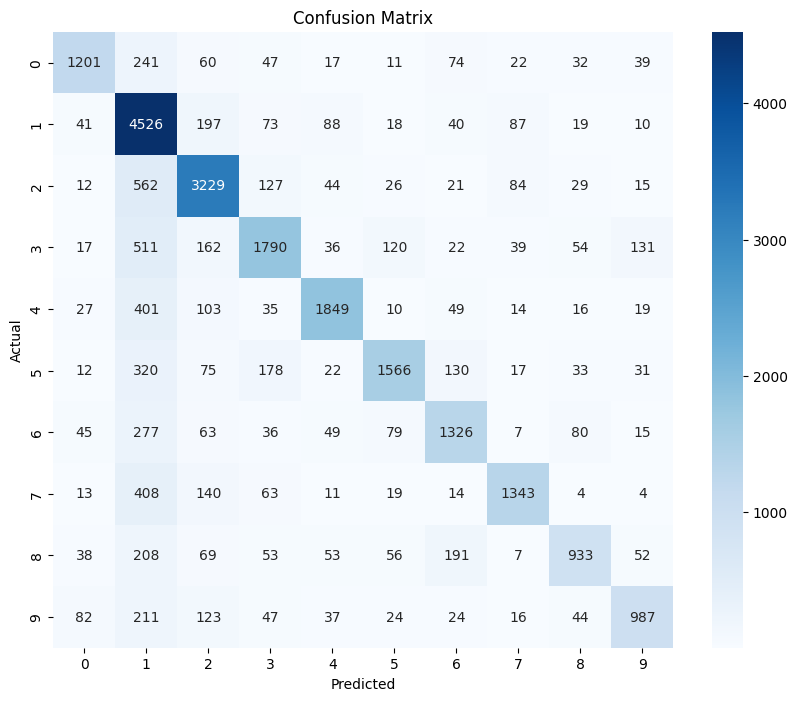

Visualizing some misclassified images:


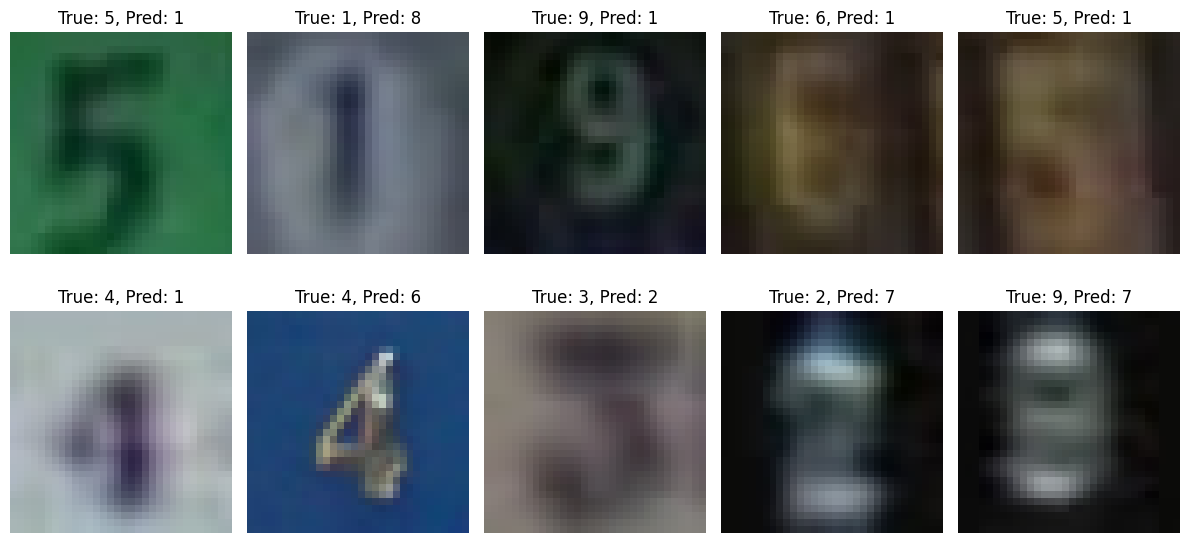

Adversarial Test Accuracy (Epsilon = 0.1): 72.03%


In [8]:
# new
# Function to display the confusion matrix
def display_confusion_matrix(labels, preds, class_names):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Function to visualize some misclassified images
def visualize_misclassified_images(misclassified_images, class_names):
    if misclassified_images:
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        axes = axes.ravel()
        for i in range(min(10, len(misclassified_images))):
            img, true_label, pred_label, *_ = misclassified_images[i]


            # Ensure the image is on CPU, detach it from the computation graph, and convert it to numpy
            img = img.detach().cpu().permute(1, 2, 0).numpy()  # Convert to HWC format
            img = np.clip(img * 0.5 + 0.5, 0, 1)  # Clip values between 0 and 1 for display
            img = np.clip(img, 0, 1)  # Clip values between 0 and 1 for display

            axes[i].imshow(img)
            axes[i].set_title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()


# Display confusion matrix
class_names = [str(i) for i in range(10)]  # Assuming 10 classes (e.g., 0-9 for MNIST)
display_confusion_matrix(all_labels, all_preds, class_names)

# Visualize misclassified images
print("Visualizing some misclassified images:")
visualize_misclassified_images(misclassified_images, class_names)

# Discuss the performance
print(f"Adversarial Test Accuracy (Epsilon = 0.1): {accuracy:.2f}%")


## Part 4: Contrastive Learning

### Code

Do the following:

1. Create a CNN that makes embeddings for images (you can use pretrained foundation models if you'd like).
2. Implement any unsupervised contrastive loss (such as nt-xent in SimCLR).
3. Train the model (achieve loss less than 3.0).

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # For visualization
from sklearn.manifold import TSNE  # Dimensionality Reduction


TRAIN_PATH =  "extracted_tiny_imagenet200/tiny-imagenet-200/train"
TEST_PATH =  "extracted_tiny_imagenet200/tiny-imagenet-200/test"
BATCH_SIZE = 256

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        """
        Initialize the dataset with the root directory and the transform to be applied.
        """
        self.root = root
        self.transform = transform
        self.imgs = []
        for label in os.listdir(root):
            if os.path.isdir(os.path.join(root, label, 'images')):
                for img in os.listdir(os.path.join(root, label, 'images')):
                    self.imgs.append(os.path.join(root, label, 'images', img))

    def __len__(self):
        """
        Return the length of the dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx):
        """
        Fetch the image and apply two different augmentations to it.
        """
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')  # Ensure it's in RGB format

        if self.transform:
            img1 = self.transform(img)  # First random augmentation
            img2 = self.transform(img)  # Second random augmentation
        else:
            img1, img2 = img, img

        return img1, img2  # Return both augmented versions


class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imgs = []
        for label in os.listdir(root):
            for img in os.listdir(os.path.join(root, label)):
                self.imgs.append(os.path.join(root, label, img))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img_transform = self.transform(img)
        return transforms.ToTensor()(img), img_transform  # Return the original image (for visualization) and the image that will be used in the model

# Training data augmentations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(96),  # Random crop and resize to 96x96
    transforms.RandomHorizontalFlip(),  # Flip horizontally with 50% probability
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.8),  # Apply color jitter with 80% probability
    transforms.RandomGrayscale(p=0.2),  # Convert to grayscale with 20% probability
    transforms.RandomRotation(15),  # Random rotation within 15 degrees
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to mean 0.5 and std 0.5
])

# Testing data augmentations
test_transforms = transforms.Compose([
    transforms.Resize(96),  # Resize to 96x96
    transforms.CenterCrop(96),  # Optional: ensure images are cropped to the center
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to mean 0.5 and std 0.5
])


train_data = TrainDataset(TRAIN_PATH, transform=data_transforms)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_data = TestDataset(TEST_PATH, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
from torchvision import models

class SimCLR_Encoder(nn.Module):
    def __init__(self):
        super(SimCLR_Encoder, self).__init__()

        # Load a pretrained ResNet-18 model
        resnet = models.resnet18(pretrained=True)

        # Use the ResNet-18 layers as the encoder (remove the fully connected layer)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final FC layer

        # Define the projection head (for mapping features to embeddings)
        self.projection_head = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 128),  # Map ResNet features to 128-d space
            nn.ReLU(),                              # Non-linear activation
            nn.Linear(128, 64)                      # Map to final 64-d embeddings
        )

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection_head(features)
        return embeddings

In [ ]:
def nt_xent_loss(embeddings1, embeddings2, temperature=0.5):
    batch_size = embeddings1.size(0)
    embeddings = torch.cat([embeddings1, embeddings2], dim=0)
    similarity_matrix = torch.matmul(embeddings, embeddings.T) / temperature
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)]).to(embeddings.device)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(similarity_matrix, labels)
    return loss

In [ ]:
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR_Encoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = GradScaler()

num_epochs = 5
accumulation_steps = 4
batch_size = 8

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        for i, (img1, img2) in enumerate(tepoch):
            img1, img2 = img1.to(device, non_blocking=True), img2.to(device, non_blocking=True)

            # Mixed precision training
            with autocast():
                embeddings1, embeddings2 = model(img1), model(img2)
                loss = nt_xent_loss(embeddings1, embeddings2, temperature=1.0) / accumulation_steps

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Perform optimization step every `accumulation_steps` batches
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item() * accumulation_steps
            tepoch.set_postfix(loss=loss.item() * accumulation_steps)

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

    torch.cuda.empty_cache()


Epoch [1/5]:   0%|          | 0/390 [00:00<?, ?batch/s]

Epoch [1/5]: 100%|██████████| 390/390 [10:09<00:00,  1.56s/batch, loss=2.42]


Epoch [1/5], Avg Loss: 2.9899


Epoch [2/5]: 100%|██████████| 390/390 [09:54<00:00,  1.52s/batch, loss=2.07]


Epoch [2/5], Avg Loss: 2.1226


Epoch [3/5]: 100%|██████████| 390/390 [09:49<00:00,  1.51s/batch, loss=1.83]


Epoch [3/5], Avg Loss: 1.9167


Epoch [4/5]: 100%|██████████| 390/390 [09:48<00:00,  1.51s/batch, loss=1.76]


Epoch [4/5], Avg Loss: 1.8109


Epoch [5/5]: 100%|██████████| 390/390 [09:49<00:00,  1.51s/batch, loss=1.82]

Epoch [5/5], Avg Loss: 1.7423


Using the function ```plot_embeddings```, show the model's performance on the test data.

In [ ]:
def plot_embeddings(model, test_loader,device):
    """
    This function creates embeddings for each image in the first batch of the test loader, projects them to 2D and displays them on a plot.
    """
    for img, img_transform in test_loader:
        img_transform = img_transform.to(device)
        embeddings = model(img_transform)
        tsne = TSNE(n_components=2)
        embeddings = tsne.fit_transform(embeddings.cpu().detach().numpy())

        fig, ax = plt.subplots()
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        for i in range(embeddings.shape[0]):
            curr_img = img[i].permute(1,2,0)
            curr_img = OffsetImage(curr_img, zoom=0.5)
            ab = AnnotationBbox(curr_img, embeddings[i], frameon=False)
            ax.add_artist(ab)
        plt.show()
        return

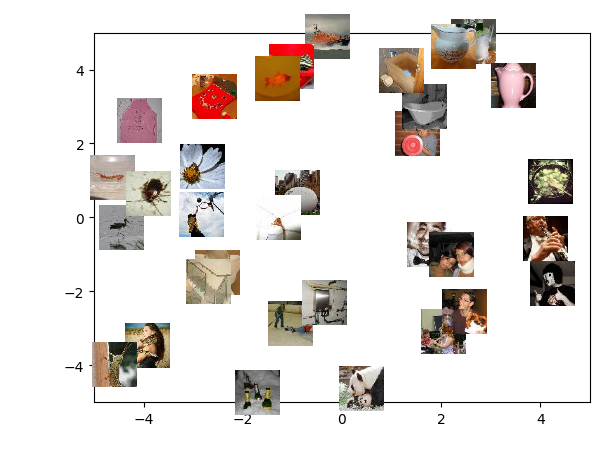

In [ ]:
plot_embeddings(model, test_loader,device)

For some batch of the test loader, take 3 images in the batch. For each image, find and display the 5 images that have the closest embeddings to them. Do the chosen images make sense? If not, what could have possibly gone wrong with your model?

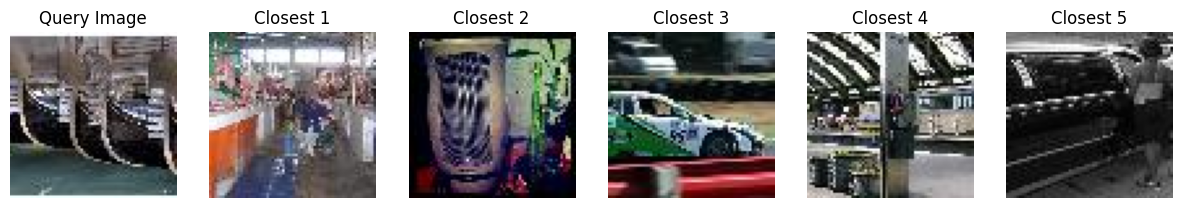

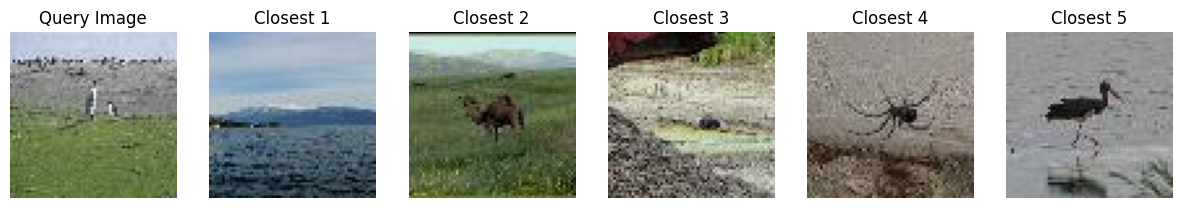

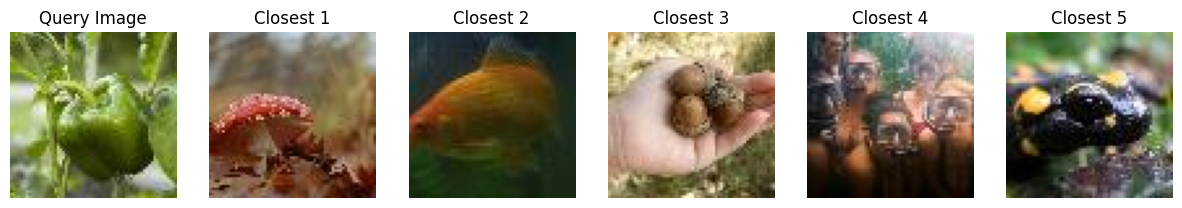

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def find_closest_images(model, test_loader, num_images=3, num_closest=5):

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for img_batch, img_transformed_batch in test_loader:
            # Move transformed images to the device
            img_transformed_batch = img_transformed_batch.to(device)

            # Compute embeddings for the entire batch
            embeddings = model(img_transformed_batch)
            embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings to unit vectors

            # Randomly select `num_images` query images
            indices = torch.randperm(len(img_batch))[:num_images]
            selected_imgs = img_batch[indices]  # Original (non-transformed) images
            selected_embeddings = embeddings[indices]  # Corresponding embeddings

            # Compute pairwise distances between selected embeddings and all embeddings
            distances = torch.cdist(selected_embeddings, embeddings, p=2)  # Euclidean distance

            # Visualize results
            for i, (img, dist) in enumerate(zip(selected_imgs, distances)):
                # Get the indices of the closest images (excluding the query itself)
                closest_indices = dist.topk(num_closest + 1, largest=False).indices[1:]

                # Display the query image and the closest images
                fig, axes = plt.subplots(1, num_closest + 1, figsize=(15, 5))
                axes[0].imshow(img.permute(1, 2, 0))  # Convert CHW to HWC for display
                axes[0].set_title("Query Image")
                axes[0].axis("off")

                for j, idx in enumerate(closest_indices):
                    closest_img = img_batch[idx].permute(1, 2, 0)  # Convert CHW to HWC
                    axes[j + 1].imshow(closest_img)
                    axes[j + 1].set_title(f"Closest {j+1}")
                    axes[j + 1].axis("off")

                plt.show()

            # Process only the first batch
            break

# Call the function
find_closest_images(model, test_loader)
